In [ ]:
!pip3 uninstall pandas

In [1]:
!pip install --upgrade -q gspread

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

ModuleNotFoundError: No module named 'pandas'

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

# setup
gc = gspread.authorize(GoogleCredentials.get_application_default())

# read data and put it in a dataframe
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1AwqUNB68gx-KSlfYSib4RMGOEeHAViuElRsUFoA1cNA/edit?usp=sharing')
# sheets = gsheets.worksheet('data available').get_all_values()
# df = pd.DataFrame(sheets[1:], columns=sheets[0])

In [ ]:
sheets = gsheets.worksheet('All').get_all_values()

In [ ]:
raw_df = pd.DataFrame(sheets[1:], columns=sheets[0])
raw_df

,Dog,Elephant,Snake,Pig,Cow,Fish,Cat,Steak,Kebab,Pork,Salad,Tomato,Onion,Car,Motorcycle,Bike,Plane,Skateboard,Helicopter,Bicycle,Computer,Keyboard,Monitor,CPU,TV,Phone
0,Does a dog have ears?,The appearance of the Asiatic elephant is fami...,There could be a snake in the daylight.,"If I promise not to act like a misogynist pig,...","The Latin word for ""cow"" is vacca.",The fish flipped and dived back into the water.,I think the cat wants dessert!,That's a long way to drive for steak and potat...,"The insane person, who will actually eat a kebab.","Your pork chops were a big hit, by the way.",He stirred his potato salad thoughtfully.,"The tomato plants were drooping, their crop re...","It is also known as the underground onion, fro...",Her car was in full view.,"However, talented artists can usually blend de...",The bike comes out tomorrow.,I'll make a plane reservation.,It is a small park with a skateboard area.,We've got a helicopter on the way.,The boy no doubt inherits a capacity for ridin...,A computer can do some tasks better than a per...,"She began to paw at her computer keyboard, sea...","As he lifted the computer monitor, he caught s...","This year, Sony is seeking to top themselves w...",It's as safe as watching TV and a darned sight...,"The phone woke me up, even though it wasn't ve..."
1,Then let's have a seat and watch the puppy dog...,"Further, the skin is stated to be much less ro...","A mouse she could handle – literally, but a sn...","Oh, what a pig I am! he repeated, flushing sud...",Can't you eat a cow or a rabbit or something?,I ate very small fish for supper.,I'm in no mood to watch a cat fight tonight.,They each ordered a salad and steak and attack...,"You haven't had a dodgy doner kebab, have you?",The city is a manufacturing and railway centre...,She spread some salad dressing on a piece of b...,"Try a crusty panini filled with soppressata, f...","The inhabitants of Pelusium in lower Egypt, wh...",Could we make a car that can go 300 mph?,"Because of this, it's important that you take ...",The last 200 miles of the bus ride traversed t...,I'm still not going to watch your plane leave.,Finding the right skateboard can sound like qu...,The helicopter dropped and caught.,He ran out to his bicycle and pushed the kicks...,I haven't been near a computer since before I ...,The keyboard has five keys similar to those of...,It's my responsibility to monitor and deter th...,And uses almost ALL CPU to actually log in.,The only thing you watch on TV is football and...,Is he listening to your phone call?
2,My dog scared them away.,The Indian region is the home of the Indian el...,"If there is a snake under it, that puts a rock...","He couldn't very well say, 'I really am that p...",Although the technique of growing cowpox on co...,"You can be a cold fish, sometimes.",The cat would like to eat the mouse.,He forked a steak off the serving tray and han...,I followed with Fish kebab (£ 10.95) - a bumpe...,"It is known for its pork pies, and has a trade...",Sarah came home as she was putting the tuna sa...,"Salads include traditional antipasto, as well ...",As our fairies give gold which changes into wi...,The car warmed quickly and she fell asleep again.,Motorcycle Superstore is filled with motorcycl...,"Time to go back to keeping the county safe, 'f...",The only thing left to do was pack and take a ...,"I'm 33, female, I skateboard a little, have do...",The helicopter lifted away before Brady had tw...,The only thing you watch on TV is football and...,Her phone and computer are monitored.,Each channel consists of a keyboard and receiv...,He turned away from the monitor and searched h...,We replaced the CPU soak tested for 48 hours a...,Let's go watch TV in the family room.,Martha handed her the phone and I could tell b...
3,"He held out his hand for the dog to sniff, but...",South of the Thames the thoroughfares crossing...,"In tropical waters a sea snake is found, which...","In 2006, a pig was genetically engineered t

In [ ]:
df = pd.DataFrame({'raw_character_text' : [], 'spoken_words': []})
df

,raw_character_text,spoken_words


In [ ]:
for column in raw_df.columns:
  for value in raw_df[column]:
    if value:
      df = df.append({'raw_character_text': column, 'spoken_words': value}, ignore_index=True)

df

,raw_character_text,spoken_words
0,Dog,Does a dog have ears?
1,Dog,Then let's have a seat and watch the puppy dog...
2,Dog,My dog scared them away.
3,Dog,"He held out his hand for the dog to sniff, but..."
4,Dog,This dog helped him watch the sheep.
...,...,...
6066,Phone,It was an independent lab and when Cynthia too...
6067,Phone,"Before leaving the Beaumont, he looked at the ..."
6068,Phone,"The phone rang, precluding a pithy rejoinder, ..."
6069,Phone,Dean handed the phone to his wife as the light...


In [ ]:
df['raw_character_text'].value_counts()

Car           385
Fish          340
Keyboard      329
Dog           326
Computer      324
Cow           292
Monitor       292
Phone         286
Snake         257
TV            256
Bike          254
Tomato        253
Steak         252
Pig           251
Motorcycle    248
Salad         232
Plane         228
Pork          213
Cat           212
Bicycle       191
Onion         181
Elephant      168
Helicopter    166
CPU            68
Skateboard     50
Kebab          17
Name: raw_character_text, dtype: int64

In [ ]:
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [ ]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop and (len(token) > 2 or str(token).lower() == 'tv')]

    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [ ]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.24 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(5817, 1)

In [ ]:
df_clean

,clean
1,let seat watch puppy dog parade
2,dog scare away
3,hold hand dog sniff nikolai nuzzle nose instead
4,dog help watch sheep
5,poor owner crumple van sob accordioned quarter...
...,...
6066,independent lab cynthia take bathroom break fr...
6067,leave beaumont look recently publish ouray pho...
6068,phone rang preclude pithy rejoinder cynthia el...
6069,dean hand phone wife light go like comic book ...


In [ ]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in df_clean['clean']]

phrases = Phrases(sent, min_count=5, progress_per=100)

bigram = Phraser(phrases)

sentences = bigram[sent]

INFO - 23:51:28: collecting all words and their counts
INFO - 23:51:28: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 23:51:28: PROGRESS: at sentence #100, processed 1340 words and 2097 word types
INFO - 23:51:28: PROGRESS: at sentence #200, processed 2738 words and 4012 word types
INFO - 23:51:28: PROGRESS: at sentence #300, processed 3595 words and 5038 word types
INFO - 23:51:28: PROGRESS: at sentence #400, processed 4868 words and 6634 word types
INFO - 23:51:28: PROGRESS: at sentence #500, processed 6264 words and 8222 word types
INFO - 23:51:28: PROGRESS: at sentence #600, processed 7449 words and 9660 word types
INFO - 23:51:28: PROGRESS: at sentence #700, processed 8478 words and 10846 word types
INFO - 23:51:28: PROGRESS: at sentence #800, processed 9991 words and 12528 word types
INFO - 23:51:28: PROGRESS: at sentence #900, processed 11108 words and 13776 word types
INFO - 23:51:28: PROGRESS: at sentence #1000, processed 12146 words and 14957 word types


In [ ]:
sentences[0]

['let', 'seat', 'watch', 'puppy', 'dog', 'parade']

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

11821

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['fish',
 'car',
 'computer',
 'dog',
 'monitor',
 'snake',
 'bike',
 'keyboard',
 'steak',
 'cat']

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=8,
                     window=4,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 23:51:42: collecting all words and their counts
INFO - 23:51:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:51:42: collected 11821 word types from a corpus of 59273 raw words and 5817 sentences
INFO - 23:51:42: Loading a fresh vocabulary
INFO - 23:51:42: effective_min_count=8 retains 1601 unique words (13% of original 11821, drops 10220)
INFO - 23:51:42: effective_min_count=8 leaves 39389 word corpus (66% of original 59273, drops 19884)
INFO - 23:51:42: deleting the raw counts dictionary of 11821 items
INFO - 23:51:42: sample=6e-05 downsamples 1601 most-common words
INFO - 23:51:42: downsampling leaves estimated 14800 word corpus (37.6% of prior 39389)
INFO - 23:51:42: estimated required memory for 1601 words and 300 dimensions: 4642900 bytes
INFO - 23:51:42: resetting layer weights


Time to build vocab: 0.01 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 23:51:51: training model with 1 workers on 1601 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=4
INFO - 23:51:51: worker thread finished; awaiting finish of 0 more threads
INFO - 23:51:51: EPOCH - 1 : training on 59273 raw words (14653 effective words) took 0.3s, 51846 effective words/s
INFO - 23:51:52: worker thread finished; awaiting finish of 0 more threads
INFO - 23:51:52: EPOCH - 2 : training on 59273 raw words (14681 effective words) took 0.3s, 50167 effective words/s
INFO - 23:51:52: worker thread finished; awaiting finish of 0 more threads
INFO - 23:51:52: EPOCH - 3 : training on 59273 raw words (14593 effective words) took 0.3s, 53484 effective words/s
INFO - 23:51:52: worker thread finished; awaiting finish of 0 more threads
INFO - 23:51:52: EPOCH - 4 : training on 59273 raw words (14946 effective words) took 0.3s, 53975 effective words/s
INFO - 23:51:53: worker thread finished; awaiting finish of 0 more threads
INFO - 23:51:53: EPOCH - 5 

Time to train the model: 0.15 mins


In [ ]:
w2v_model.init_sims(replace=True)

INFO - 23:52:12: precomputing L2-norms of word weight vectors


In [ ]:
w2v_model.wv.most_similar(positive=["cat"],topn=15)

[('show', 0.9999154806137085),
 ('say', 0.999912679195404),
 ('reach', 0.9999126195907593),
 ('buy_motorcycle', 0.999911367893219),
 ('detail', 0.9999113082885742),
 ('word', 0.9999113082885742),
 ('shape', 0.9999110698699951),
 ('train', 0.999910295009613),
 ('close', 0.9999100565910339),
 ('speak', 0.9999099969863892),
 ('thing', 0.9999098777770996),
 ('kill', 0.9999096393585205),
 ('rock', 0.999909520149231),
 ('finally', 0.9999092817306519),
 ('right', 0.9999091625213623)]

In [ ]:
w2v_model.wv.similarity("dog", 'cat')

0.9998966

In [ ]:
w2v_model.wv.doesnt_match(['dog', 'cat', 'bike'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'bike'

In [ ]:
w2v_model.wv.most_similar(positive=["elephant", "monitor"], negative=["tv"], topn=3)

[('rhinocero', 0.9997884035110474),
 ('crocodile', 0.9997789859771729),
 ('hog', 0.9997754693031311)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

In [ ]:
col_names = [x.lower() for x in df['raw_character_text'].unique()]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


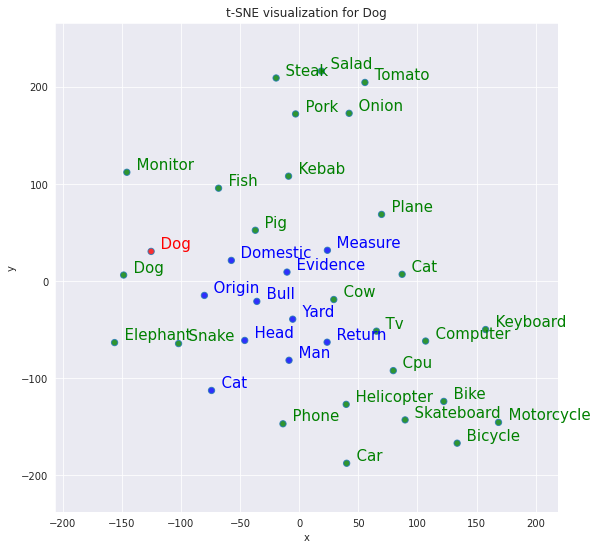

In [ ]:
tsnescatterplot(w2v_model, 'dog', col_names)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


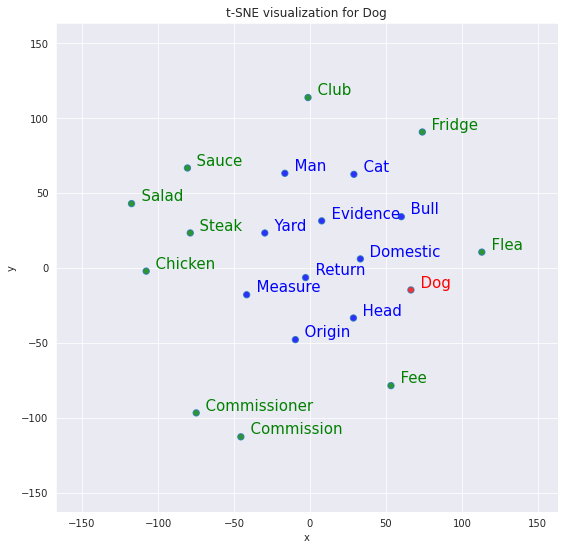

In [ ]:
tsnescatterplot(w2v_model, 'dog', [i[0] for i in w2v_model.wv.most_similar(negative=["dog"])])

In [ ]:
word_annotations = {
 'dog': 'animal',
 'elephant': 'animal',
 'snake': 'animal',
 'pig': 'animal',
 'cow': 'animal',
 'fish': 'animal',
 'cat': 'animal',
 'steak': 'food',
 'kebab': 'food',
 'pork': 'food',
 'salad': 'food',
 'tomato': 'food',
 'onion': 'food',
 'car': 'vehicle',
 'motorcycle': 'vehicle',
 'bike': 'vehicle',
 'plane': 'vehicle',
 'skateboard': 'vehicle',
 'helicopter': 'vehicle',
 'bicycle': 'vehicle',
 'computer': 'device',
 'keyboard': 'device',
 'monitor': 'device',
 'cpu': 'device',
 'tv': 'device',
 'phone': 'device',
}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


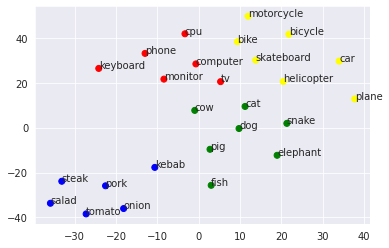

In [ ]:
colors = {'animal':'green', 'food':'blue', 'vehicle':'yellow', 'device':'red'}

X = []

for col in col_names:
  X.append(w2v_model.wv[col])

tsne = TSNE(n_components=2, n_iter=3000, random_state=np.random.RandomState(30), perplexity=10)
X_tsne = tsne.fit_transform(X)

c = [colors[word_annotations[x]] for x in col_names]

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=c)

for i, txt in enumerate(X):
    ax.annotate(col_names[i], (X_tsne[:, 0][i], X_tsne[:, 1][i]))

In [ ]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

INFO - 23:59:01: Creating /root/gensim-data


[==================================================] 100.0% 376.1/376.1MB downloaded


INFO - 00:00:24: glove-wiki-gigaword-300 downloaded
INFO - 00:00:24: loading projection weights from /root/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz
INFO - 00:02:33: loaded (400000, 300) matrix from /root/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz


In [ ]:
glove_vectors.most_similar('dog')

INFO - 00:03:31: precomputing L2-norms of word weight vectors


[('dogs', 0.788855791091919),
 ('cat', 0.681674599647522),
 ('pet', 0.6291598081588745),
 ('puppy', 0.5936061143875122),
 ('hound', 0.5468214750289917),
 ('horse', 0.5369751453399658),
 ('animal', 0.5316445827484131),
 ('cats', 0.5080744028091431),
 ('canine', 0.5038435459136963),
 ('pets', 0.501996636390686)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


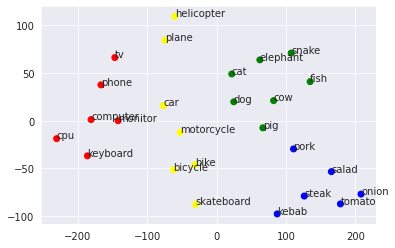

In [ ]:
X = []

for col in col_names:
  X.append(glove_vectors.wv[col])

tsne = TSNE(n_components=2, n_iter=3000, random_state=np.random.RandomState(20), perplexity=10)
X_tsne = tsne.fit_transform(X)

c = [colors[word_annotations[x]] for x in col_names]

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=c)

for i, txt in enumerate(X):
    ax.annotate(col_names[i], (X_tsne[:, 0][i], X_tsne[:, 1][i]))

In [ ]:
glove_vectors.wv.most_similar(positive=["woman", "king"], negative=["queen"], topn=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('man', 0.6788584589958191),
 ('father', 0.5293229818344116),
 ('person', 0.5283361673355103)]